In [1]:
import sqlite3
import pandas as pd
import os
import re
import numpy as np
from sklearn import cross_validation, metrics
from sklearn.metrics import accuracy_score, roc_curve, auc,  precision_recall_curve, average_precision_score
from sklearn.grid_search import GridSearchCV
from nltk.tokenize import sent_tokenize, word_tokenize, StanfordTokenizer
from nltk.corpus import stopwords
#from bs4 import BeautifulSoup
import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 4
import string
import seaborn as sns
sns.set_style("whitegrid")
os.chdir('/Users/RayLJazz//Dropbox/iidata')

# Read Data

In [71]:
ffclean = pd.read_csv('food_p3.csv')

In [72]:
ffclean.shape, ffclean.columns

((5608, 18), Index(['country_cleaned', 'brands_cleaned', 'packaging_cleaned',
        'catgory_cleaned', 'quan_unit', 'additives_n',
        'ingredients_that_may_be_from_palm_oil_n', 'energy_100g', 'fat_100g',
        'saturated_fat_100g', 'carbohydrates_100g', 'sugars_100g', 'fiber_100g',
        'proteins_100g', 'salt_100g', 'sodium_100g', 'nutrition_score_fr_100g',
        'nutrition_score_uk_100g'],
       dtype='object'))

In [86]:
Class = []
def identify_class(row):
    if (row['catgory_cleaned']=='Sugary snacks'):
        Class.append(int(2))
    elif (row['catgory_cleaned']=='Groceries'):
        Class.append(int(0))
    elif (row['catgory_cleaned']=='Plant-based foods and beverages'):
        Class.append(int(3))
    else:
        Class.append(int(1))

In [87]:
ffclean_class = ffclean.apply(identify_class,axis=1)

In [88]:
Class_df = pd.Series(data=Class)
ffclean['palm_Class'] = Class_df
ffclean['palm_Class'].value_counts()

1    3127
3    1512
2     634
0     335
Name: palm_Class, dtype: int64

In [89]:
#Class_char = pd.Categorical.from_codes(ffclean['palm_Class'], ['No', 'Yes'])
#ffclean['Class_char'] = Class_char
ffclean=ffclean.replace('NA', np.nan)
ffclean=ffclean.replace('NaN', np.nan)
ffclean_rna = ffclean

In [90]:
ffclean_rna.head(n=10)
target = 'palm_Class'
Predictors = [x for x in ffclean_rna.columns if x not in ['brands_cleaned','quan_unit','catgory_cleaned','country_cleaned','palm_Class','packaging_cleaned']]
Predictors 

['additives_n',
 'ingredients_that_may_be_from_palm_oil_n',
 'energy_100g',
 'fat_100g',
 'saturated_fat_100g',
 'carbohydrates_100g',
 'sugars_100g',
 'fiber_100g',
 'proteins_100g',
 'salt_100g',
 'sodium_100g',
 'nutrition_score_fr_100g',
 'nutrition_score_uk_100g']

In [32]:
import pickle
with open('ffclean_rna.pickle', 'wb') as handle:
    pickle.dump(ffclean_rna, handle,protocol=2)

In [25]:
ffclean_rna=pd.read_pickle('ffclean_rna.pickle')

In [35]:
ffclean_rna[Predictors].shape

(75059, 27)

In [91]:
train_x, test_x, train_y, test_y = cross_validation.train_test_split(ffclean_rna[Predictors], ffclean_rna['palm_Class'], test_size=0.3,random_state=1,stratify=ffclean['palm_Class'])

In [92]:
train_x.shape, test_x.shape, train_y.shape, test_y.shape

((3925, 13), (1683, 13), (3925,), (1683,))

In [93]:
train_y.value_counts(),  test_y.value_counts()

(1    2189
 3    1058
 2     444
 0     234
 Name: palm_Class, dtype: int64, 1    938
 3    454
 2    190
 0    101
 Name: palm_Class, dtype: int64)

## Extreme Gradient Boosting

### Step 1- Find the number of estimators for a high learning rate

In [94]:
import xgboost as xgb
from xgboost.sklearn import XGBClassifier

In [95]:
train = train_x
train['Score'] = train_y
test = test_x
test['Score'] = test_y

In [96]:
train.shape, test.shape

((3925, 14), (1683, 14))

In [97]:
def modelfit(alg, dtrain, dtest, predictors,target, useTrainCV=True, cv_folds=5, early_stopping_round=50):
    
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(dtrain[predictors].values, label=dtrain[target].values,missing=np.nan)
        xgtest = xgb.DMatrix(dtest[predictors].values,missing=np.nan)
        xgb_param_forcv = xgb_param
        xgb_param_forcv['num_class'] = 4
        cvresult = xgb.cv(xgb_param_forcv, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
             early_stopping_rounds=early_stopping_round, show_progress=True)
        alg.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the algorithm on the data
    alg.fit(dtrain[predictors], dtrain[target],eval_metric='merror')
    
    #Predict training set:
    dtrain_predictions = alg.predict(dtrain[predictors])
    #dtrain_predprob = alg.predict_proba(dtrain[predictors])[:,1]
    return alg, dtrain_predictions
   

In [98]:
xgb1 = XGBClassifier(
        learning_rate =0.1,
        n_estimators=1000,
        max_depth=5,
        min_child_weight=1,
        gamma=0,
        subsample=0.8,
        colsample_bytree=0.8,
        objective= 'multi:softmax',
        nthread=4,
        scale_pos_weight=1,
        seed=27)
xgb1, dtrain_predictions = modelfit(xgb1, train, test, Predictors,'Score')

Will train until cv error hasn't decreased in 50 rounds.
/Users/RayLJazz/miniconda3/lib/python3.5/xgboost/training.py:272: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  idset = [randidx[(i * kstep): min(len(randidx), (i + 1) * kstep)] for i in range(nfold)]
[0]	cv-test-merror:0.25452240000000004+0.009093888378466067	cv-train-merror:0.2142036+0.01201900382893691
[1]	cv-test-merror:0.2359238+0.014308284724592257	cv-train-merror:0.19522319999999999+0.0049048331429315745
[2]	cv-test-merror:0.23719739999999997+0.012465993431732597	cv-train-merror:0.18687899999999996+0.0051369554407255675
[3]	cv-test-merror:0.2303188+0.019004364113539823	cv-train-merror:0.1869428+0.005438368005201561
[4]	cv-test-merror:0.23337560000000002+0.017249836782995957	cv-train-merror:0.1817196+0.006268736127801203
[5]	cv-test-merror:0.2318474+0.015413518126631573	cv-train-merror:0.1791082+0.004270650648320462
[6]	cv-test-merror:0.2285352+0.01396891

In [101]:
target = 'Score'
def get_performance(xgbmodel,dtrain,dtest,predictors,dtrain_predictions):
    print ("\nModel Report")
    print ("Train accuracy : %.4g" % metrics.accuracy_score(dtrain[target].values, dtrain_predictions))
    test_result = xgbmodel.predict(dtest[predictors])
    dtest_predprob = xgbmodel.predict_proba(dtest[predictors])[:,1]
    print ("Test accuracy : %.4g" % metrics.accuracy_score(dtest[target].values, test_result))
    print (pd.crosstab(dtest[target].values, test_result, rownames=['actual'], colnames=['preds']))
    feat_imp = pd.Series(xgbmodel.booster().get_fscore()).sort_values(ascending=False)
    feat_imp.plot(kind='barh', title='Feature Importances').invert_yaxis()
    plt.ylabel('Feature Importance Score')


Model Report
Train accuracy : 0.9786


/Users/RayLJazz/miniconda3/lib/python3.5/xgboost/core.py:840: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  preds = preds.reshape(nrow, preds.size / nrow)


Test accuracy : 0.8188
preds    0    1    2    3
actual                   
0       61   28    0   12
1       20  823   39   56
2        0   35  148    7
3        6   91   11  346


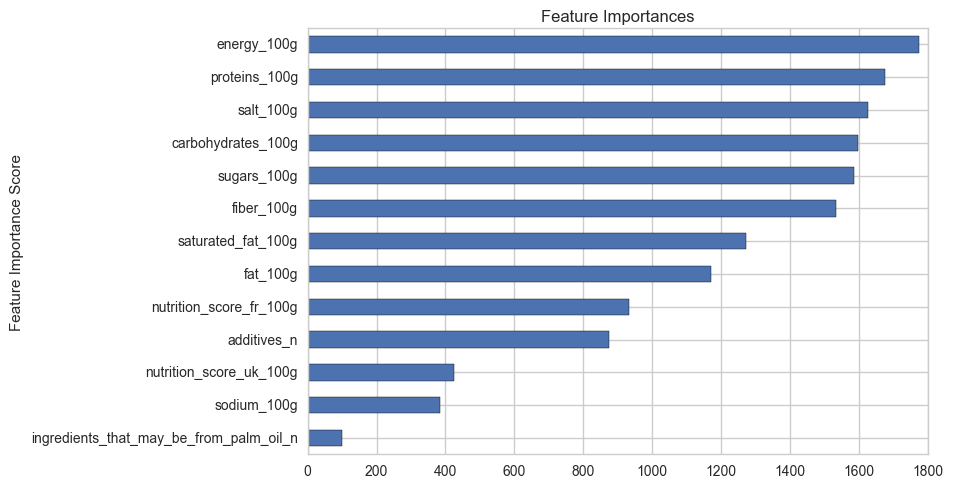

In [102]:
get_performance(xgb1,train,test,Predictors,dtrain_predictions)